#**MAXIMUM POOLING**

#Extracción de características

La extracción de características consiste de tres operaciones básicas:


1.   **Filtrar** una imagen para una característica particular (convolución)
2.   **Detectar** las características dentro de la imagen filtrada (ReLU)
##3.   **Agrupar** para mejorar las característcas (maximum pooling)

Esta operación puede realizarse con Keras por la capa `MaxPool2D`, se parece a la capa `Conv2D`, excepto que usa una función simple del máximo, con el parámetro `pool_size` análogo a `kernel_size`, esta capa no necesita entrenar pesos. En el modelo se vería como:

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # Más capas
])

Recordemos:

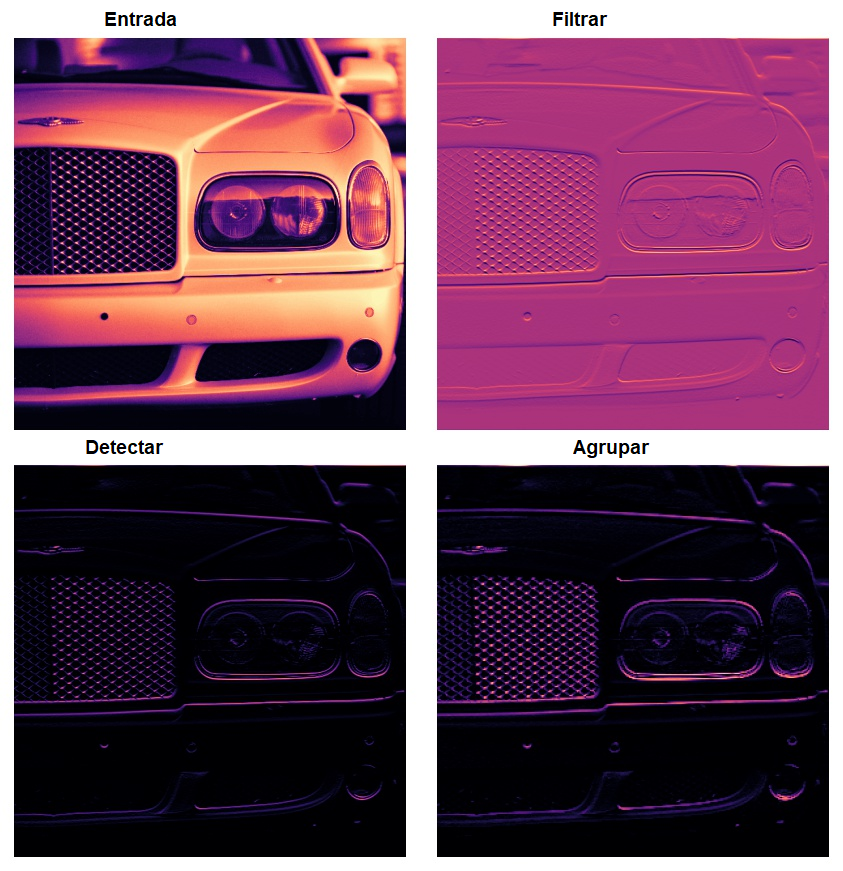

Note que después de aplicar la función ReLu (Detección) el feature maps termina con muchos "espacios muertos" (conteniendo muchos 0, áreas negras en la imagen). Estas activaciones 0 incrementan el tamaño del modelo sin aportar mucha información útil. Por lo que se puede **agrupar** el mapa manteniendo la parte útil.

Max pooling toma un patch de activaciones en el feature map original y lo reemplaza con la activación máxima en ese patch.

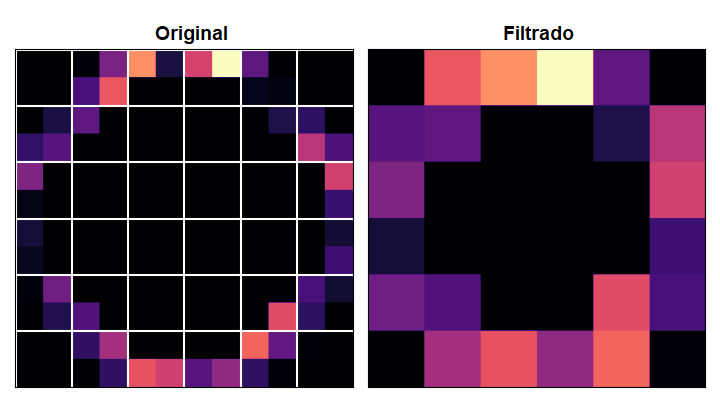

Cuando se aplica después de una activación ReLU, tiene el efecto de *intensificar* características. El pooling incrementa la proporción de pixeles activados a pixeles ceros.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") 

In [ ]:
#Leer imagen
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving car_feature.jpg to car_feature.jpg
User uploaded file "car_feature.jpg" with length 41527 bytes


In [ ]:
image_path = 'car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

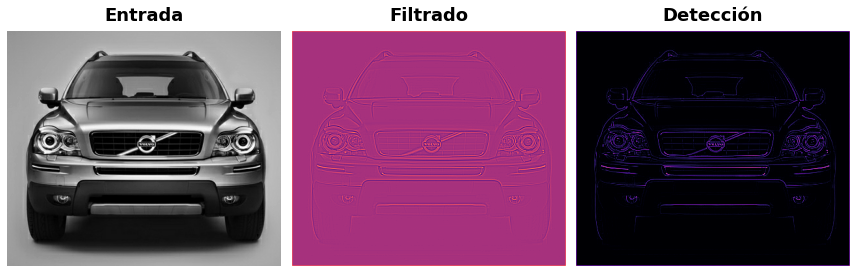

In [ ]:
# Definir kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformatear para compatibilidad
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filtrado
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME'
)

# Detección
image_detect = tf.nn.relu(image_filter)

# Muestra lo que se vió antes
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Entrada')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filtrado')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detección')
plt.show();


Para aplicar el paso de agrupamiento se puede usar **tf.nn.pool**.

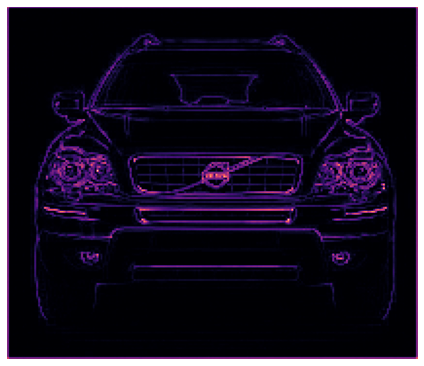

In [ ]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # imagen del paso anterior
    window_shape=(2, 2),
    pooling_type='MAX',
    # esto se verá más adelante
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

##Invarianza en la transformación 

A los pixeles cero les llamamos "no-importantes", pero contienen información *posicional*. Las posiciones en blanco, por otro lado mantienen las posiciones de las caracerísticas dentro de la imagen. MaxPool2D elimina algunos de estos pixeles, quita información posicional. La propiedad de invarianza en la transformación, signifca que una CNN con maximum pooling tenderá a no distinguir características por su posición en la imágen.

Por ejemplo:

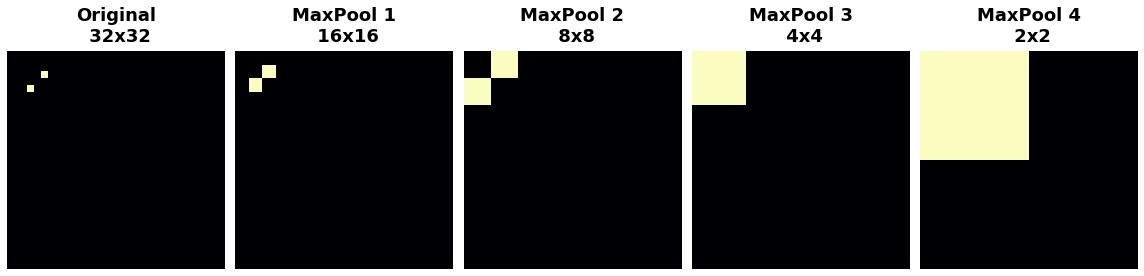

Los dos puntos en la imagen original se vuelven indistinguibles después de varios pooling. En otras palabras, destruye información posicional. Ya que la red no los distingue en el feature map tampoco lo hará en la imagen orginal. Esto sucede con distancias pequeñas.

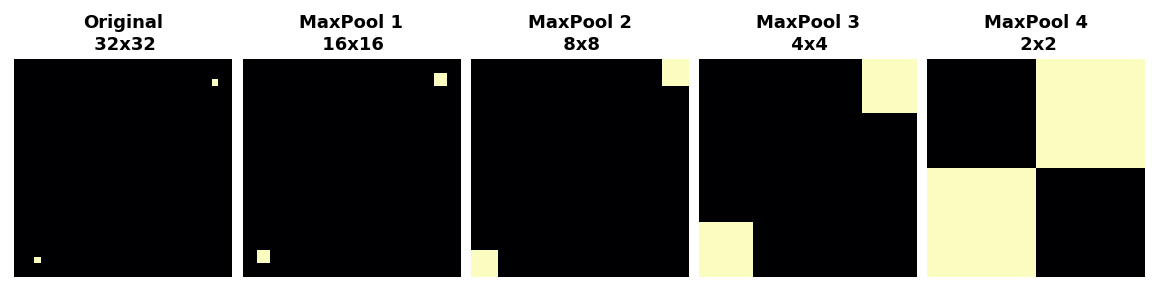

##Ejercicio

Vamos a terminar la extracción de características del ejercicio anterior, aplicar el maximum pooling y compararlo con el average pooling.

In [ ]:
#Leer la imagen car_illus.jpg
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving car_illus.jpg to car_illus.jpg
User uploaded file "car_illus.jpg" with length 1532483 bytes


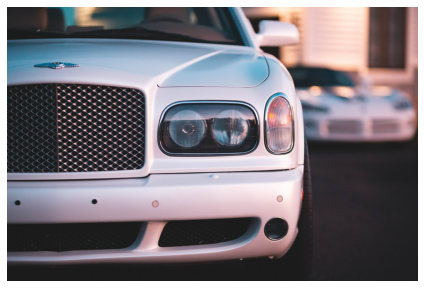

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = 'car_illus.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

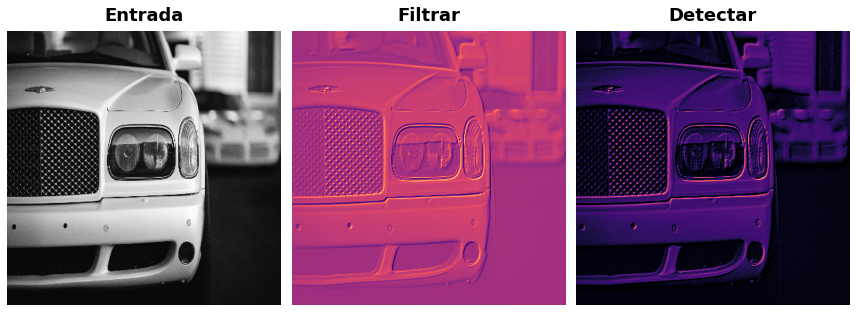

In [ ]:
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# Kernel de relieve
kernel = tf.constant([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
])

# Reformatear para compatibilidad
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)

image_detect = tf.nn.relu(image_filter)

# Mostrar 
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Entrada')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filtrar')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detectar')
plt.show();

**1. Aplicar pooling para agrupar**

Aplicar maximum pooling usando una ventana de 2x2, puede copiar el siguiente código

```
image_condense = tf.nn.pool(
    input=image_detect,
    window_shape=____,
    pooling_type=____,
    strides=(2, 2),
    padding='SAME',
)

```




In [ ]:
image_condense = tf.nn.pool(
    ---
)


Ejecute la siguiente celda para ver qué hizo maximum pooling

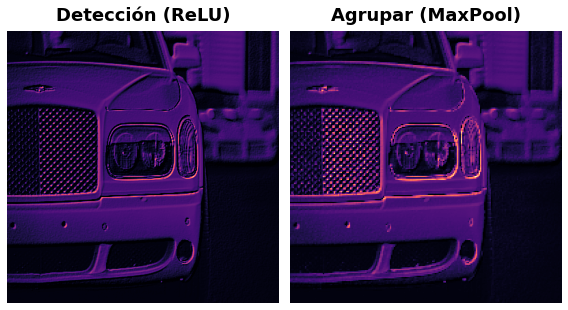

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detección (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Agrupar (MaxPool)")
plt.show();

**2. Global Average Pooling**

Este tipo de agrupamiento se acostumbra ponerlo en el head de la CNN en lugar de varias capas Dense.



```
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])
```

Note que ya no está la capa `Flatten` que se usa después de la base para transformar los datos 2D en 1D. La capa `GlobalAvgPool2D` sirve para realizar esta función, pero en lugar de apilar, reemplaza el feature map con su valor promedio. Algunas veces funciona bien reduciendo el número de parámetros del modelo.


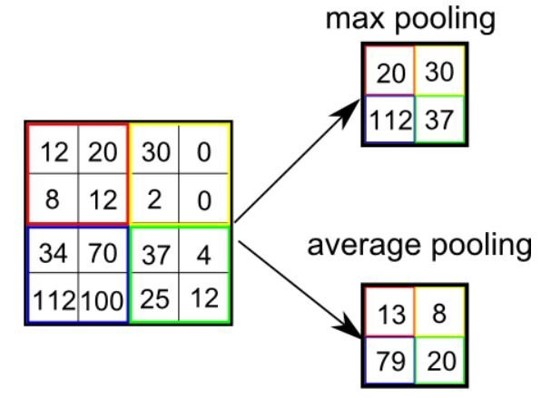

Algo importante es determinar si el agrupamiento deja suficiente información para determinar la pertenencia a una clase.

Para hacer esto, se usará el dataset Car or Truck a través de una VGG16 y se examinaran los resultados después del agrupamiento.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Cargar VGG16
pretrained_base = VGG16 (include_top = False, input_shape=(224,224,3))
pretrained_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model = keras.Sequential([
    pretrained_base,
    # Insertar una capa average pooling
    layers.GlobalAvgPool2D(),
])
model.summary ()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Lectura del dataset
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving car-or-truck.zip to car-or-truck.zip
User uploaded file "car-or-truck.zip" with length 81730251 bytes


In [ ]:
import io
import zipfile

data = zipfile.ZipFile (io.BytesIO(uploaded['car-or-truck.zip']))
data.extractall ()

In [ ]:
#Cargar datset

ds = image_dataset_from_directory(
    'car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[224, 224],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)

Found 5117 files belonging to 2 classes.


`VGG` produce un feature map por cada imagen. El `GlobalAvgPool2D` reduce cada uno a un solo valor, el "average pixel",

Ejecute varias veces la siguiente celda y observe la salida producida por carros vs. caminionetas.

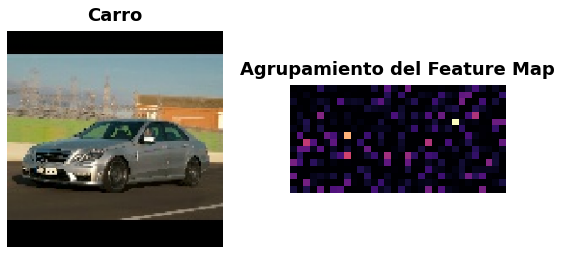

In [ ]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[224, 224])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy ())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Carro", "Camioneta"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Agrupamiento del Feature Map')
plt.axis('off')
plt.show();

**3. Interpretación**

¿Qué se vió? 

Son diferentes los agrupamientos entre los dos, cómo se podrían interpretar

si la característica está presente el número calculado será mayor.